#Загрузка моделей и библиотек

In [1]:
!pip install catboost
!pip install pymorphy2
!pip install patool

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import pymorphy2
import patoolib
import os
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from transformers import BertTokenizer, BertModel
from sklearn.cluster import DBSCAN
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, precision_recall_curve, classification_report, accuracy_score
from catboost import CatBoostClassifier, Pool
from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

/Users/taniyashuba/PycharmProjects/VK_ML_Project/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Загрузка данных

In [3]:
# Загрузка данных
train_groups = pd.read_csv('train_groups.csv')
test_groups = pd.read_csv('test_groups.csv')
sample_submission = pd.read_csv('sample_submission.csv')
docs_titles = pd.read_csv('docs_titles.tsv', sep='\t')

In [4]:
# Объединение заголовков с данными групп
train_data = train_groups.merge(docs_titles, on='doc_id')
test_data = test_groups.merge(docs_titles, on='doc_id', how='left')

In [5]:
# Просмотр пропусков
train_data.isna().sum(), test_data.isna().sum()

(pair_id      0
 group_id     0
 doc_id       0
 target       0
 title       16
 dtype: int64,
 pair_id      0
 group_id     0
 doc_id       0
 title       92
 dtype: int64)

In [6]:
# Обработка отсутствующих значений
train_data['title'].fillna('', inplace=True)
test_data['title'].fillna('', inplace=True)

# Предобработка данных

In [7]:
# Загрузка данных для NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Стоп-слова и шум
stop_words = set(stopwords.words('russian')) | set(stopwords.words('english'))

# Пробуем стеммер или леммер
# stemmer = SnowballStemmer("russian")
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/taniyashuba/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/taniyashuba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/taniyashuba/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
def preprocess_text(text):
    """
    Токенизация + лемматизация/стемминг текста
    """
    text = re.sub(r'<.*?>', '', text)  # Удаление HTML-тегов
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9\s]', '', text.lower())  # Удаление спецсимволов
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words and not token.isdigit()]
    # tokens = [stemmer.stem(word) for word in tokens]
    tokens = [morph.parse(word)[0].normal_form for word in tokens]
    return tokens

train_data['title_processed'] = train_data['title'].apply(preprocess_text)
test_data['title_processed'] = test_data['title'].apply(preprocess_text)

# Векторизация BERT

In [9]:
# Векторизация с помощью BERT
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embeddings(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().cpu()

train_data['title_embeddings'] = train_data['title'].apply(lambda x: get_bert_embeddings(x).numpy())
test_data['title_embeddings'] = test_data['title'].apply(lambda x: get_bert_embeddings(x).numpy())

# Создание фичей

## BERT фичи

In [10]:
def embeddings_to_features(data, column_prefix):
    """
    Преобразуем эмбеддинги в фичи
    """
    embeddings = np.stack(data[column_prefix + '_embeddings'].values)
    feature_names = [f"{column_prefix}_embedding_{i}" for i in range(embeddings.shape[1])]
    features_df = pd.DataFrame(embeddings, columns=feature_names, index=data.index)
    return features_df

train_features = embeddings_to_features(train_data, 'title')
test_features = embeddings_to_features(test_data, 'title')

In [11]:
def add_new_features(data):
    """
    Добавляем новые признаки: длина заголовка и число уникальных слов
    """
    data['title_length'] = data['title'].apply(lambda x: len(x.split()))
    data['unique_words'] = data['title_processed'].apply(lambda x: len(set(x)))
    return data

train_data = add_new_features(train_data)
test_data = add_new_features(test_data)

## Косинусные сходства Tfidf

In [12]:
def vectorize_group(group):
    """
    Векторизуем группу документов с кастомным токенайзером
    """
    vectorizer = TfidfVectorizer(tokenizer=preprocess_text)
    vectors = vectorizer.fit_transform(group['title'])
    return vectors

In [13]:
def data_to_tfidf(data_grouped):
    """
    Создание tfidf матрицы для данных по группам
    """
    tfidf_data = pd.DataFrame()
    for name, group in tqdm(data_grouped, desc="Processing groups"):
        # Для каждой группы получаем векторное представление
        tfidf_matrix = vectorize_group(group)
        tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])], index=group.index)
        # Соединяем в df все группы
        tfidf_data = pd.concat([tfidf_data, tfidf_df])
    return tfidf_data

In [14]:
def cosine_matrix_group(group):
    """
    Вычисление матрицы косинусных расстояний для группы
    """
    tfidf_matrix = vectorize_group(group)
    cosine_matrix = cosine_similarity(tfidf_matrix)
    return cosine_matrix

In [15]:
def calc_cosine_similarity(data_grouped, count=10):
    """
    Возвращаем топ косинусных сходств для каждого документа группы
    """
    similarity_features_list = []
    for name, group in tqdm(data_grouped, desc="Processing groups"):
        cosine_matrix = cosine_matrix_group(group)
        for k, (idx, row) in enumerate(group.iterrows()):
            similarities = []
            for j in range(len(group)):
                if k == j:
                    continue
                similarities.append(cosine_matrix[k, j])
            top_similarities = sorted(similarities, reverse=True)[:count]
            similarity_record = [row['pair_id']] + top_similarities
            similarity_features_list.append(similarity_record)
    similarity_columns = ['pair_id'] + [f'top_{i+1}_similarity' for i in range(count)]
    similarity_features = pd.DataFrame(similarity_features_list, columns=similarity_columns)
    return similarity_features

# Кластеризация

In [16]:
def clustering_features(data_grouped, eps=0.5, min_samples=5, metric='cosine'):
    """
    Возвращаем кластер для каждого документа группы
    """
    clustering_features_list = []
    for name, group in tqdm(data_grouped, desc="Processing groups"):
        cosine_matrix = cosine_matrix_group(group)
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(cosine_matrix)
        cluster_labels = dbscan.labels_
        for k, (idx, row) in enumerate(group.iterrows()):
            clustering_record = [row['pair_id'], cluster_labels[k]]
            clustering_features_list.append(clustering_record)
    clustering_columns = ['pair_id', 'cluster']
    clustering_features = pd.DataFrame(clustering_features_list, columns=clustering_columns)
    return clustering_features

# Работа с остальным текстом

In [ ]:
# def preprocess_bigtext(text):
#     """
#     Токенизация + лемматизация/стемминг текста
#     """
#     text = re.sub(r'<.*?>', '', text)  # Удаление HTML-тегов
#     text = re.sub(r'http\S+|www\S+|https\S+|@\S+', '', text)  # Удаление URL и email-адресов
#     text = re.sub(r'[^a-zA-Zа-яА-Я0-9\s]', '', text.lower())  # Удаление спецсимволов
#     text = re.sub(r'\s+', ' ', text).strip()  # Удаление дополнительных пробелов

#     tokens = word_tokenize(text.lower())
#     tokens = [token for token in tokens if token not in stop_words and not token.isdigit() and len(token) > 1]
#     # tokens = [stemmer.stem(word) for word in tokens]
#     tokens = [morph.parse(word)[0].normal_form for word in tokens]
#     return tokens

In [ ]:
# from google.colab import drive

# drive.mount('/content/drive')

In [ ]:
# doc_to_text = pd.read_csv('/content/drive/MyDrive/doc_texts_processed.tsv', sep='\t')
# doc_to_text = doc_to_text.drop_duplicates(subset='doc_id')

# train_texts = train_data.merge(doc_to_text, on='doc_id')
# train_texts.shape

In [ ]:
# train_texts['text_processed'].fillna('', inplace=True)
# train_texts.isna().sum()

In [ ]:
# train_texts['text_processed_str'] = train_texts['text_processed'].apply(lambda tokens: tokens.replace("'",'').replace("[",'').replace("]", '').replace(",", ''))

In [ ]:
# def get_most_common_tokens(tokens, top_n=10):
#     counter = Counter(tokens)
#     most_common = counter.most_common(top_n)
#     return [(token, freq) for token, freq in most_common]

In [ ]:
# # Словарь для хранения токенов групп
# group_tokens = {}

# ignore_tokens = {'год', 'время', 'который', 'это'} | stop_words

# # Обработка каждой группы
# for group_id, group_data in tqdm(train_texts.groupby('group_id'), desc="Processing Groups"):
#     all_tokens = []

#     # Сбор токенов всех документов группы
#     for tokens in group_data['text_processed']:
#         filtered_tokens = [token for token in tokens if token not in ignore_tokens]
#         all_tokens.extend(filtered_tokens)

#     # Получение самых частых токенов группы
#     group_tokens[group_id] = get_most_common_tokens(all_tokens, top_n=10)

In [ ]:
# # Функция для сравнения топ-10 слов документа с топ-10 словами группы с учетом веса
# def compare_top_tokens_weighted(doc_tokens, group_top_tokens, top_n=10):
#     doc_top_tokens = get_most_common_tokens(doc_tokens, top_n)
#     doc_top_dict = {token: (top_n - rank) for rank, (token, _) in enumerate(doc_top_tokens)}
#     print(doc_top_dict)
#     group_top_dict = {token: (top_n - rank) for rank, (token, _) in enumerate(group_top_tokens)}
#     print(group_top_dict)
#     common_weight = 0
#     for token in doc_top_dict:
#         if token in group_top_dict:
#             common_weight += doc_top_dict[token] * group_top_dict[token]

#     max_weight = sum((top_n - rank) ** 2 for rank in range(top_n))  # Максимально возможный вес
#     similarity = common_weight / max_weight  # Нормализованное сходство

#     return similarity


# # Сравнение топ-10 слов каждого документа с топ-10 словами группы
# for group_id, group_data in train_texts.groupby('group_id'):
#     group_top_tokens = group_tokens[group_id]
#     for index, row in group_data.iterrows():
#         doc_tokens = row['text_processed']
#         similarity = compare_top_tokens_weighted(doc_tokens, group_top_tokens, top_n=10)
#         print(row['pair_id'], similarity)

In [ ]:
# def vectorize_bigtext_group(group):
#     """
#     Векторизуем группу документов с кастомным токенайзером
#     """
#     vectorizer = TfidfVectorizer(min_df=0.1)
#     vectors = vectorizer.fit_transform(group['text_processed_str'])
#     return vectors


# def cosine_matrix_bigtext_group(group):
#     """
#     Вычисление матрицы косинусных расстояний для группы
#     """
#     tfidf_matrix = vectorize_bigtext_group(group)
#     cosine_matrix = cosine_similarity(tfidf_matrix)
#     return cosine_matrix


# def calc_cosine_similarity_bigtext(data_grouped, count=10):
#     """
#     Возвращаем топ косинусных сходств для каждого документа группы
#     """
#     similarity_features_list = []
#     for name, group in tqdm(data_grouped, desc="Processing groups"):
#         cosine_matrix = cosine_matrix_bigtext_group(group)
#         for k, (idx, row) in enumerate(group.iterrows()):
#             similarities = []
#             for j in range(len(group)):
#                 if k == j:
#                     continue
#                 similarities.append(cosine_matrix[k, j])
#             top_similarities = sorted(similarities, reverse=True)[:count]
#             similarity_record = [row['pair_id']] + top_similarities
#             similarity_features_list.append(similarity_record)
#     similarity_columns = ['pair_id'] + [f'top_{i+1}_text_similarity' for i in range(count)]
#     similarity_features = pd.DataFrame(similarity_features_list, columns=similarity_columns)
#     return similarity_features

In [ ]:
# train_bigtext_similarity_features = calc_cosine_similarity_bigtext(train_texts.groupby('group_id'))
# train_bigtext_similarity_features

Processing groups: 100%|██████████| 129/129 [00:56<00:00,  2.28it/s]


,pair_id,top_1_text_similarity,top_2_text_similarity,top_3_text_similarity,top_4_text_similarity,top_5_text_similarity,top_6_text_similarity,top_7_text_similarity,top_8_text_similarity,top_9_text_similarity,top_10_text_similarity
0,1,0.978158,0.972459,0.900609,0.792005,0.699219,0.600406,0.543437,0.439064,0.431675,0.410208
1,2,0.913469,0.909362,0.811142,0.730911,0.721916,0.715256,0.690753,0.351321,0.340670,0.264956
2,3,0.506538,0.338334,0.330525,0.325923,0.306376,0.302372,0.280024,0.267377,0.256891,0.249371
3,4,0.303914,0.235285,0.203242,0.194214,0.181018,0.180893,0.165241,0.160630,0.142960,0.130732
4,5,0.710733,0.600787,0.580851,0.580675,0.549624,0.546537,0.542367,0.472085,0.439064,0.432103
...,...,...,...,...,...,...,...,...,...,...,...
11685,11686,0.548244,0.528663,0.508516,0.499606,0.494534,0.485516,0.473773,0.468624,0.444055,0.439630
11686,11687,0.347428,0.329538,0.326162,0.318191,0.315450,0.294175,0.286890,0.286553,0.283058,0.282136
11687,11688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11688,11689,0.621112,0.334816,0.331274,0.318953,0.317680,0.307089,0.306404,0.301483,0.301048,0.300976


# Косинусные сходства BERT embeddings

In [ ]:
# def emb_cosine_matrix_group(group):
#     """
#     Вычисление матрицы косинусных расстояний для группы
#     """
#     emb_matrix = np.vstack(group['title_embeddings'].values)
#     cosine_matrix = cosine_similarity(emb_matrix)
#     return cosine_matrix

In [ ]:
# def emb_cosine_similarity(data_grouped, count=10):
#     """
#     Возвращаем топ косинусных расстояний для группы по эмбеддингам
#     """
#     similarity_features_list = []
#     for name, group in tqdm(data_grouped, desc="Processing groups"):
#         cosine_matrix = emb_cosine_matrix_group(group)
#         for k, (idx, row) in enumerate(group.iterrows()):
#             similarities = []
#             for j in range(len(group)):
#                 if k == j:
#                     continue
#                 similarities.append(cosine_matrix[k, j])
#             top_similarities = sorted(similarities, reverse=True)[:count]
#             similarity_record = [row['pair_id']] + top_similarities
#             similarity_features_list.append(similarity_record)
#     similarity_columns = ['pair_id'] + [f'top_{i+1}_emb_similarity' for i in range(count)]
#     similarity_features = pd.DataFrame(similarity_features_list, columns=similarity_columns)
#     return similarity_features

# WMD дистанции

In [ ]:
# !pip install POT
# import gensim.downloader as api
# word2vec = api.load('word2vec-ruscorpora-300')

In [ ]:
# def remove_pos_tag(word):
#     return word.split('_')[0]

# key_to_index_no_pos = {remove_pos_tag(word): word for word in word2vec.key_to_index}


# def transform_text(text):
#     """
#     Преобразует текст в список токенов, которые соответствуют форматам слов в модели
#     """
#     transformed_text = [key_to_index_no_pos[word] for word in text if word in key_to_index_no_pos]
#     return transformed_text


# def wmd_features(data_grouped, model, count=10):
#     """
#     Возвращаем топ WMD расстояний для группы
#     """
#     distances_features_list = []
#     for name, group in tqdm(data_grouped, desc="Processing groups"):
#         for k, (idx, row) in enumerate(group.iterrows()):
#             distances = []
#             transformed_k = transform_text(group['title_processed'].iloc[k])
#             for j in range(len(group)):
#                 if k == j:
#                     continue
#                 transformed_j = transform_text(group['title_processed'].iloc[j])
#                 distances.append(model.wmdistance(transformed_k, transformed_j))
#             top_distances = sorted(distances)[:count]
#             distance_record = [row['pair_id']] + top_distances
#             distances_features_list.append(distance_record)
#     distance_columns = ['pair_id'] + [f'top_{i+1}_distances' for i in range(count)]
#     distance_features = pd.DataFrame(distances_features_list, columns=distance_columns)
#     return distance_features

# Объединение данных и фичей в датасет

In [16]:
# Разбиваем train и test по группам на основе id
train_data_grouped = train_data.groupby('group_id')
test_data_grouped = test_data.groupby('group_id')

In [17]:
# Фичи для трейна и теста
train_similarity_features = calc_cosine_similarity(train_data_grouped)
train_clustering_features = clustering_features(train_data_grouped)

test_similarity_features = calc_cosine_similarity(test_data_grouped)
test_clustering_features = clustering_features(test_data_grouped)

# Заполняем пропуски нулями
train_similarity_features = train_similarity_features.fillna(0)

test_similarity_features = test_similarity_features.fillna(0)

# Объединяем новые признаки с исходным датасетом
train_data = train_data.merge(train_similarity_features, on=['pair_id'])
train_data = train_data.merge(train_clustering_features, on=['pair_id'])

test_data = test_data.merge(test_similarity_features, on=['pair_id'])
test_data = test_data.merge(test_clustering_features, on=['pair_id'])

Processing groups: 100%|██████████| 180/180 [00:46<00:00,  3.88it/s]


In [18]:
# Объединяем с BERT признаками
train_data = pd.concat([train_data, train_features], axis=1)
test_data = pd.concat([test_data, test_features], axis=1)

# Разбиение на train, val и test

In [20]:
X_train = train_data.drop(columns=['doc_id', 'pair_id', 'group_id', 'target', 'title', 'title_processed', 'title_embeddings'], axis=1)
y_train = train_data['target']

X_test = test_data.drop(columns=['doc_id', 'pair_id', 'group_id', 'title', 'title_processed', 'title_embeddings'], axis=1)

In [21]:
# Разбиение данных на обучающую и тестовую выборки
splitter = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_indices, val_indices = next(splitter.split(X_train, y_train, train_groups['group_id']))

X_train_split = X_train.iloc[train_indices]
y_train_split = y_train.iloc[train_indices]
    
X_val_split = X_train.iloc[val_indices]
y_val_split = y_train.iloc[val_indices]

In [ ]:
# # Скейлинг данных
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_split)
# X_val_scaled = scaler.transform(X_val_split)

# Обучение и инференс модели

In [22]:
# Обучение модели CatBoost
model = CatBoostClassifier()
train_pool = Pool(X_train_split, y_train_split)
val_pool = Pool(X_val_split, y_val_split)
model.fit(train_pool, eval_set=val_pool)

Learning rate set to 0.053361
0:	learn: 0.6606098	test: 0.6584773	best: 0.6584773 (0)	total: 712ms	remaining: 11m 50s
1:	learn: 0.6268560	test: 0.6239720	best: 0.6239720 (1)	total: 1.08s	remaining: 8m 59s
2:	learn: 0.6033026	test: 0.5983232	best: 0.5983232 (2)	total: 1.47s	remaining: 8m 7s
3:	learn: 0.5795323	test: 0.5742138	best: 0.5742138 (3)	total: 1.94s	remaining: 8m 1s
4:	learn: 0.5587873	test: 0.5527478	best: 0.5527478 (4)	total: 2.33s	remaining: 7m 43s
5:	learn: 0.5384167	test: 0.5316621	best: 0.5316621 (5)	total: 2.69s	remaining: 7m 25s
6:	learn: 0.5214387	test: 0.5145717	best: 0.5145717 (6)	total: 2.96s	remaining: 6m 59s
7:	learn: 0.5054012	test: 0.4984240	best: 0.4984240 (7)	total: 3.21s	remaining: 6m 37s
8:	learn: 0.4930599	test: 0.4854726	best: 0.4854726 (8)	total: 3.51s	remaining: 6m 26s
9:	learn: 0.4797008	test: 0.4720475	best: 0.4720475 (9)	total: 3.78s	remaining: 6m 14s
10:	learn: 0.4678868	test: 0.4600896	best: 0.4600896 (10)	total: 4.09s	remaining: 6m 7s
11:	learn: 0.

In [23]:
# Предсказания на валидационной выборке
val_predictions = model.predict(val_pool)

In [24]:
# Оценка модели на валидации
accuracy = accuracy_score(y_val_split, val_predictions)
f1 = f1_score(y_val_split, val_predictions)
report = classification_report(y_val_split, val_predictions)

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")    
print(report)

Accuracy: 0.8475609756097561
F1-score: 0.6548323471400395
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      2704
           1       0.64      0.67      0.65       740

    accuracy                           0.85      3444
   macro avg       0.77      0.78      0.78      3444
weighted avg       0.85      0.85      0.85      3444



# Стекинг

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

class DjStacking(BaseEstimator, ClassifierMixin):
    """Стэкинг моделей scikit-learn"""

    def __init__(self, models, ens_model):
        """
        Инициализация
        models - базовые модели для стекинга
        ens_model - мета-модель
        """
        self.models = models
        self.ens_model = ens_model
        self.n = len(models)
        self.valid = None

    def fit(self, groups_ids, X, y, p=0.25, cv=3, err=0.001, random_state=None):
        """
        Обучение стекинга
        p - в каком отношении делить на обучение / тест
            если p = 0 - используем всё обучение!
        cv  (при p=0) - сколько фолдов использовать
        err (при p=0) - величина случайной добавки к метапризнакам
        random_state - инициализация генератора

        """
        if (p > 0): # делим на обучение и тест
            # разбиение на обучение моделей и метамодели
            # train, valid, y_train, y_valid = train_test_split(X, y, test_size=p, random_state=random_state)
            splitter = GroupShuffleSplit(n_splits=1, test_size=p, random_state=random_state)
            train_indices, val_indices = next(splitter.split(X, y, groups=groups_ids))
            train = X.iloc[train_indices]
            y_train = y.iloc[train_indices]
            valid = X.iloc[val_indices]
            y_valid = y.iloc[val_indices]


            # заполнение матрицы для обучения метамодели
            self.valid = np.zeros((valid.shape[0], self.n))
            for t, clf in enumerate(self.models):
                clf.fit(train, y_train)
                self.valid[:, t] = clf.predict_proba(valid)[:, 1]

            # обучение метамодели
            self.ens_model.fit(X=self.valid, y=y_valid)

        else: # используем всё обучение

            # для регуляризации - берём случайные добавки
            self.valid = err*np.random.randn(X.shape[0], self.n)

            for t, clf in enumerate(self.models):
                # это oob-ответы алгоритмов
                self.valid[:, t] += cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method='predict_proba')[:, 1]
                # но сам алгоритм надо настроить
                clf.fit(X, y)

            # обучение метамодели
            self.ens_model.fit(self.valid, y)


        return self



    def predict(self, X, y=None):
        """
        Работа стэкинга
        """
        # заполение матрицы для мета-классификатора
        X_meta = np.zeros((X.shape[0], self.n))

        for t, clf in enumerate(self.models):
            X_meta[:, t] = clf.predict(X)

        a = self.ens_model.predict(X_meta)

        return (a)

## Базовые алгоритмы

In [ ]:
# Скейлинг данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.svm import SVC

knn1 = KNeighborsClassifier(n_neighbors=3)

knn2 = KNeighborsClassifier(n_neighbors=10)

svm1 = OneClassSVM()
svm1.fit(X_train_scaled, y_train)

svc1 = SVC(probability=True)

rf1 = RandomForestClassifier(n_estimators=100)

rf2 = RandomForestClassifier(n_estimators=200)

cat1 = CatBoostClassifier(valid_params)

# cat2 = model

In [ ]:
from sklearn.linear_model import LogisticRegression
models = [knn1, knn2, rf1, rf2, cat1]
ens_model = LogisticRegression()
groups_ids = train_groups['group_id']
s1 = DjStacking(models, ens_model)
s1.fit(groups_ids, X_train, y_train)

In [ ]:
# Сохранение результатов
submission = test_groups[['pair_id']].copy()
submission['target'] = preds
submission.to_csv('/content/submission.csv', index=False)

print('Файл с предсказаниями создан: submission.csv')

# Важность признаков

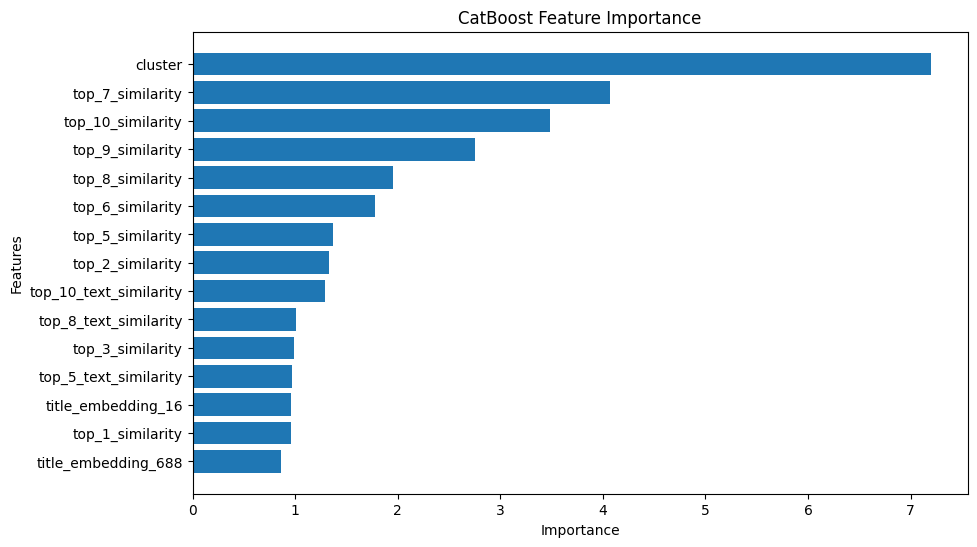

In [ ]:
import matplotlib.pyplot as plt

importances = model.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=X_train.columns).sort_values()[-15:]
feature_importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [ ]:
# Предсказание на тестовом наборе
test_pool = Pool(X_test)
test_predictions = model.predict(test_pool)

In [ ]:
# Сохранение результатов
submission = test_groups[['pair_id']].copy()
submission['target'] = test_predictions
submission.to_csv('/content/submission.csv', index=False)

print('Файл с предсказаниями создан: submission.csv')

Файл с предсказаниями создан: submission.csv


# Инференс

In [25]:
test_pool = Pool(X_test)

# Предсказание на тестовом наборе
test_predictions = model.predict(test_pool)

# Сохранение результатов
submission = test_groups[['pair_id']].copy()
submission['target'] = test_predictions
submission.to_csv('/content/submission.csv', index=False)

print('Файл с предсказаниями создан: submission.csv')

Файл с предсказаниями создан: submission.csv


In [ ]:
# test_final_predictions = final_model.predict(test_pool)

# submission = test_groups[['pair_id']].copy()
# submission['target'] = test_final_predictions
# submission.to_csv('/content/submission.csv', index=False)

# print('Файл с предсказаниями создан: submission.csv')